Porjet P2 (suite du P1)

Vous êtes nouvel embauche chez CoolCorp, une startup qui spécialise
dans l'analyse des désastres maritimes.  Un nouveau client, White Star
Lines, se trouve face à un procès à travers le temps, affaire délicat.
Votre chef vous demande, en tant que seul data scientist chez
CoolCorp, d'analyser les données `*.csv`.  WSL a déjà engagé un expert
pour annoter une partie des données (`test.csv`) avec la survie ou pas
des passagers.

Le chef comprend que vous êtes nouveau, c'est pourquoi il vous laisse
une semaine complète pour cette analyse.

J'ouvre les fichiers train et test

In [2]:
import csv as csv 
import numpy as np
import pandas as pd

datap = pd.read_csv('train.csv', header=0)
testp = pd.read_csv('test.csv', header=0)

la ligne de commande suivante détail les premiéres élément de train.csv

<b>Nettayage des données</b> 

Nettayage des données ci-dessous pour permettre des analyses plus poussée et enlevée les données non approprié
exemple:
    -des valeurs à null.
    -des colonnes en type string qui peuvent être numérisé (le sexe par exemple).

Nettayage des données: remplacer le sexe par le numerisation en 0 et 1 (booléan)

In [3]:
# Ajouter une colonne :
datap['Gender'] = 4
testp['Gender'] = 4

# Peut-être avec des valeurs plus intéressantes :
datap['Gender'] = datap['Sex'].map( lambda x: x[0].upper() )
testp['Gender'] = testp['Sex'].map( lambda x: x[0].upper() )

# Ou binaire :
datap['Gender'] = datap['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
testp['Gender'] = testp['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

Nettayage des données: remplacer les ages null par l'age mediane selon le genre et la class.

In [4]:
#nettoyage de donnée de datap et testp
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = datap[(datap['Gender'] == i) & \
                              (datap['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = testp[(testp['Gender'] == i) & \
                              (testp['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

array([[ 41.,  24.,  22.],
       [ 42.,  28.,  24.]])

on ajoute les ages dans la nouvelle colonne AgeFill puis on affiche les dix premiére 

In [5]:
datap['AgeFill'] = datap['Age']
testp['AgeFill'] = testp['Age']

on ajoute les ages medians dans la nouvelle colonne AgeFill, où les ages sont null. Puis on affiche les dix premiéres modifications

In [6]:
# Et puis on le rempli :
for i in range(0, 2):
    for j in range(0, 3):
        datap.loc[ (datap.Age.isnull()) & (datap.Gender == i) & 
                (datap.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]
datap[ datap['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head(10)

# Et puis on le rempli :
for i in range(0, 2):
    for j in range(0, 3):
        testp.loc[ (testp.Age.isnull()) & (testp.Gender == i) & 
                (testp.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]

on convertit la colonne en type integer.

In [7]:
datap['AgeIsNull'] = pd.isnull(datap.Age).astype(int)
testp['AgeIsNull'] = pd.isnull(testp.Age).astype(int)

on crée la colonne FamilySize (taille de la famille) et Age*Class

In [8]:
# parch is number of parents or children on board.
datap['FamilySize'] = datap['SibSp'] + datap['Parch']
testp['FamilySize'] = testp['SibSp'] + testp['Parch']

# Class affected survival.  Maybe age will, too.
# Who knows, maybe the product will be predictive, too.  Let's set it up.
datap['Age*Class'] = datap.AgeFill * datap.Pclass
testp['Age*Class'] = testp.AgeFill * testp.Pclass

ci-dessous, les embarcations S, C et Q deviennent 1, 2, 3 dans une nouvelle colonne
Les lignes où il n'y a rien, je leur attibut un "1" car ils sont seulement 2 et les embarcation S sont les plus nombreux.

In [9]:
datap['EmbarkedBin'] = datap['Embarked'].map( {'S': 1, 'C': 2, 'Q': 3, None: 1} )

1

<b>Analyse de l'influence de l'embarcation sur la survie</b> 

Nous allons analyser ci-dessous analyser l'influence du port d'entrée sur la survit des passagers sur le Titanic, nous allons dans un premier temps comparer le nombre de survivant de chaque embarcation et le nombre de non survivant de chaque embarcation

ci-dessous les tableaux qui les montrent

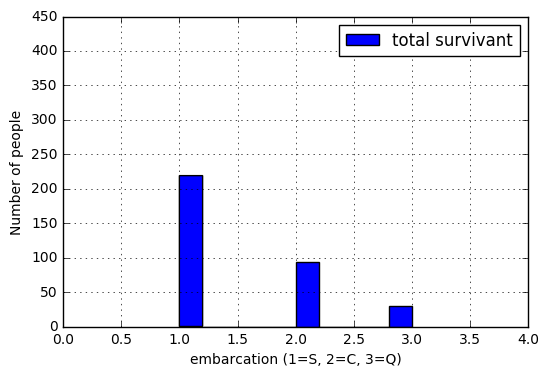

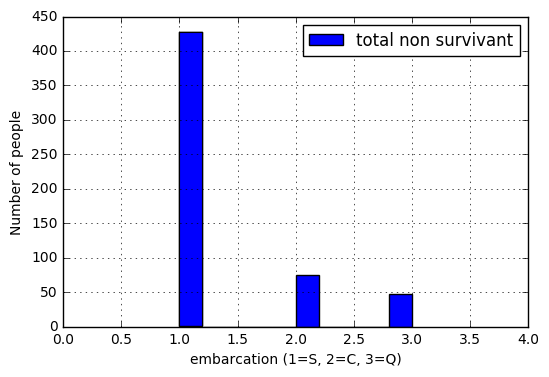

In [44]:
#graphique montrant le tarif selon l'age
import matplotlib.pyplot as plt

plt.hist(datap[datap['Survived']==1]['EmbarkedBin'], label='total survivant')
plt.xlabel('embarcation (1=S, 2=C, 3=Q)')
plt.ylabel('Number of people')
plt.legend(loc='upper right')
plt.axis([0, 4, 0, 450])
plt.grid(True)
plt.show()

plt.hist(datap[datap['Survived']==0]['EmbarkedBin'], label='total non survivant')
plt.xlabel('embarcation (1=S, 2=C, 3=Q)')
plt.ylabel('Number of people')
plt.legend(loc='upper right')
plt.axis([0, 4, 0, 450])
plt.grid(True)
plt.show()



On peut observer que l'embarcation S à le plus fort taux non survivant. L'embarcation Q a un taux de non survivant plus faible. L'embarcation C a par contre un taux de survivant supérieur à 50%.

Nous allons faire une régression linéaire pour vérifier cela et voir si cela concorde.

Coefficients: 
 [[ 0.08047508]]
Residual sum of squares: 0.22
Variance score: 0.02


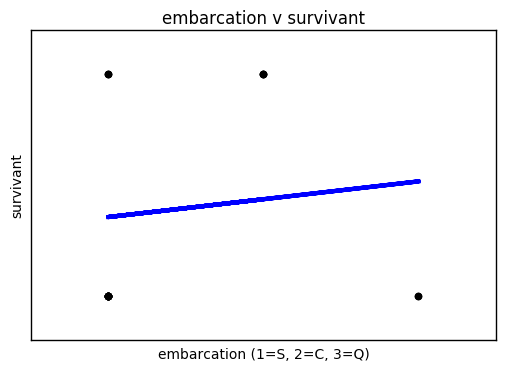

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model



# Split the data into training/testing sets
data_X_train = datap['EmbarkedBin'].to_frame()[:-20]
data_X_test = datap['EmbarkedBin'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap['Survived'].to_frame()[:-20]
data_y_test = datap['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

# Plot outputs
plt.title('embarcation v survivant')
plt.scatter(data_X_test, data_y_test,  color='black')
plt.plot(data_X_test, regr.predict(data_X_test), color='blue',
         linewidth=3)
plt.xlabel('embarcation (1=S, 2=C, 3=Q)')
plt.ylabel('survivant')
plt.xticks(())
plt.yticks(())

plt.show()

In [12]:
print(u'prediction pour embarcation S {px:.2f}'.format(
        px=regr.predict([[1]])[0][0]))
print(u'prediction pour embarcation C {px:.2f}'.format(
        px=regr.predict([[2]])[0][0]))
print(u'prediction pour embarcation Q {px:.2f}'.format(
        px=regr.predict([[3]])[0][0]))

prediction pour embarcation S 0.36
prediction pour embarcation C 0.44
prediction pour embarcation Q 0.52


On peut voir que cela ne concorde pas vraiment par rapport à ce que l'on a trouvé au-dessus. Les résidus doivent influencer cette différence (c'est une sorte courbe, elle n'est donc pas adaptée pour une régression linéaire)

<b>Analyse de l'influence de l'embarcation sur la survie, en fonction du sexe et de l'âge</b> 

Nous allons approfondir notre recherche sur la survie selon l'embarcation, en nous intéressant si la personne est un homme ou une femme, et selon son âge. On va pouvoir ainsi observer si ces critères influencent le taux de survie des embarcations.

Ci-dessous, trois graphiques représentants le nombre de femmes et d'homme selon l'âge dans chaque point d'emport.

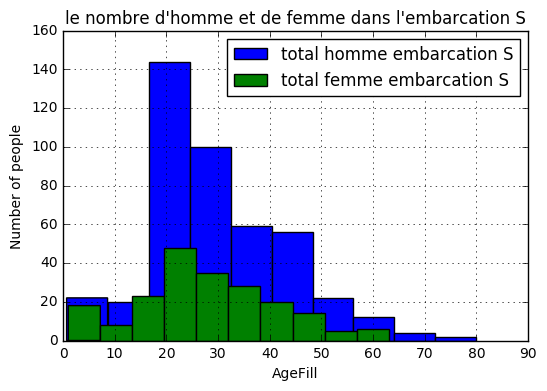

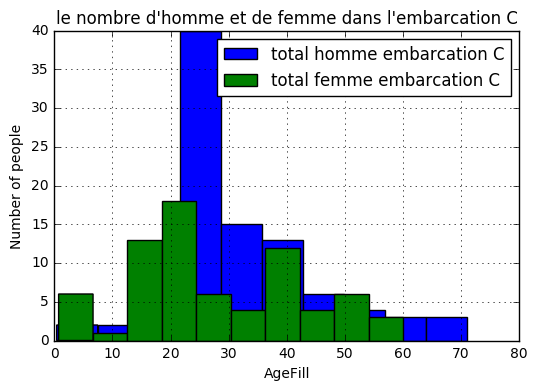

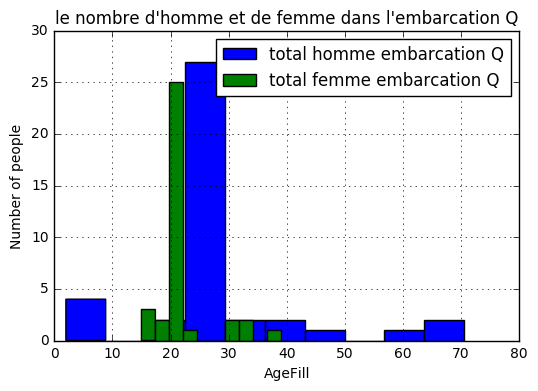

In [46]:
from matplotlib import pyplot

pyplot.hist(datap[(datap['EmbarkedBin']==1) & (datap['Sex']=='male')]['AgeFill'], label='total homme embarcation S')
pyplot.hist(datap[(datap['EmbarkedBin']==1) & (datap['Sex']=='female')]['AgeFill'], label='total femme embarcation S')
pyplot.xlabel('AgeFill')
pyplot.ylabel('Number of people')
pyplot.legend(loc='upper right')
pyplot.title('le nombre d\'homme et de femme dans l\'embarcation S')
pyplot.grid(True)
pyplot.show()
pyplot.hist(datap[(datap['EmbarkedBin']==2) & (datap['Sex']=='male')]['AgeFill'], label='total homme embarcation C')
pyplot.hist(datap[(datap['EmbarkedBin']==2) & (datap['Sex']=='female')]['AgeFill'], label='total femme embarcation C')
pyplot.xlabel('AgeFill')
pyplot.ylabel('Number of people')
pyplot.legend(loc='upper right')
pyplot.title('le nombre d\'homme et de femme dans l\'embarcation C')
pyplot.grid(True)
pyplot.show()
pyplot.hist(datap[(datap['EmbarkedBin']==3) & (datap['Sex']=='male')]['AgeFill'], label='total homme embarcation Q')
pyplot.hist(datap[(datap['EmbarkedBin']==3) & (datap['Sex']=='female')]['AgeFill'], label='total femme embarcation Q')
pyplot.xlabel('AgeFill')
pyplot.ylabel('Number of people')
pyplot.legend(loc='upper right')
pyplot.title('le nombre d\'homme et de femme dans l\'embarcation Q')
pyplot.grid(True)
pyplot.show()

Grâce à ces graphiques, on peut voir qu'il y a une proportion plus égale entre homme et femme, pour les personnes qui ont embarqué par le pont C et Q. Nous avons vu précédemment que l'emport C et Q avait un taux de survie plus élevé que l'emport S. Cela vérifie que c'est bien les femmes qui ont influencé le taux de survie sur chaque pont (en principe, les femmes sont sauvées avant les hommes).

À l'inversement, les hommes sont beaucoup plus que les femmes pour avoir embarqué sur le pont S. Cela prouve aussi le taux de survie plus en baisse par rapport aux autres ponts.

Nous pouvons conclure que les femmes ont influencé le taux de survie sur les embarcations

<b>Analyse du taux de survie selon la classe prise</b>

Pour cette deuxième analyse nous allons vérifier si la classe prise de chaque passager à influencer leur taux de survie.
Nous commençons par une régression linéaire pour vérifier le taux de survie selon la classe.

Coefficients: 
 [[-0.19321813]]
Residual sum of squares: 0.16
Variance score: 0.31


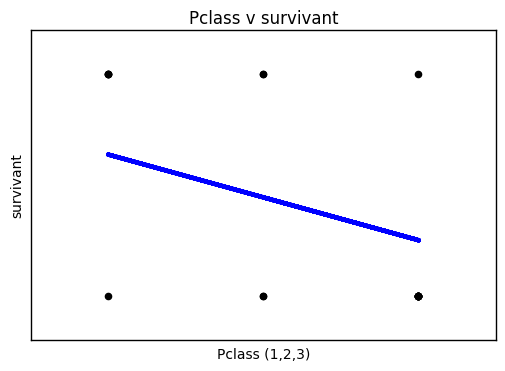

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model



# Split the data into training/testing sets
data_X_train = datap['Pclass'].to_frame()[:-20]
data_X_test = datap['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap['Survived'].to_frame()[:-20]
data_y_test = datap['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

# Plot outputs
plt.title('Pclass v survivant')
plt.scatter(data_X_test, data_y_test,  color='black')
plt.plot(data_X_test, regr.predict(data_X_test), color='blue',
         linewidth=3)
plt.xlabel('Pclass (1,2,3)')
plt.ylabel('survivant')
plt.xticks(())
plt.yticks(())

plt.show()

Grâce au graphique on peut clairement voir que si un passager prend une classe assez élevée, plus la chance de survie de celui-ci augmente. Dans le cas contraire plus la classe est faible, plus la chance de survie est faible.

ci-dessous des predictions par classe 1, 2 et 3;

In [15]:
print(u'prediction pour 1ére classe {px:.2f}'.format(
        px=regr.predict([[1]])[0][0]))
print(u'prediction pour 2éme classe {px:.2f}'.format(
        px=regr.predict([[2]])[0][0]))
print(u'prediction pour 3éme classe {px:.2f}'.format(
        px=regr.predict([[3]])[0][0]))

prediction pour 1ére classe 0.64
prediction pour 2éme classe 0.44
prediction pour 3éme classe 0.25


On peut voir que la première classe est la seule classe avec un taux de survie supérieur à 50%. la deuxième classe est proche de 50% mais elle est en dessous. Pour les 3e classés, le taux de survie est vraiment faible à 25%.

Allons plus loin dans notre raisonnement et regardons si le sexe de la personne influence ce taux de survie comme dans notre précédente analyse (selon l'embarcation)


In [ ]:
on va mainteant faire la même chose avec un la regression logistique pour voir les différences au niveau des coefficients

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets



# Split the data into training/testing sets
data_X_train = datap['Pclass'].to_frame()[:-20]
data_X_test = datap['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap['Survived'].to_frame()[:-20]
data_y_test = datap['Survived'].to_frame()[-20:]


logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(data_X_train, data_y_train)

# Erreur
print('erreur')
print(logreg.score(data_X_test, data_y_test))
# Coefficients
print('coefficients')
print(logreg.coef_)


erreur
0.8
coefficients
[[-0.83187877]]


C:\Users\romain\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Nous pouvons voir que le coefficient est de 0.8, le pouvoir prédictif du modèle est donc très forte pour la régression logistique. Elle est par contre faible pour la régression linéaire (0.19).


In [97]:

print('prediction pour 1ére classe')
print(logreg.predict(1))
print('prediction pour 2éme classe')
print(logreg.predict(2))
print('prediction pour 3éme classe')
print(logreg.predict(3))

prediction pour 1ére classe
[1]
prediction pour 2éme classe
[0]
prediction pour 3éme classe
[0]


Avec la régression logistique, les premiéres classes survient. Pour les deuxièmes et troisièmes classes, la régression prédit qu'ils ne seront pas survivant.


Ci-dessous deux régressions linéaires sûres selon les hommes et selon les femmes.

Coefficients: 
 [[-0.10393603]]
Residual sum of squares: 0.11
Variance score: 0.11


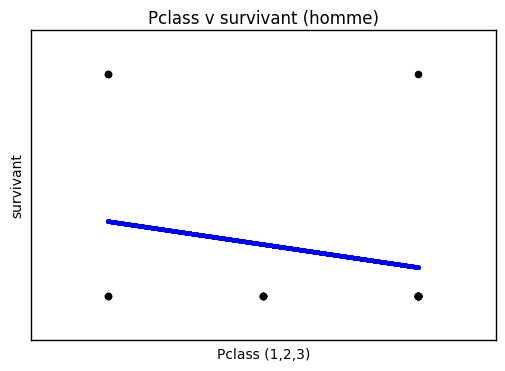

prediction pour 1ére classe 0.33
prediction pour 2éme classe 0.23
prediction pour 3éme classe 0.13
 
 
 
 
Coefficients: 
 [[-0.23972071]]
Residual sum of squares: 0.15
Variance score: 0.31


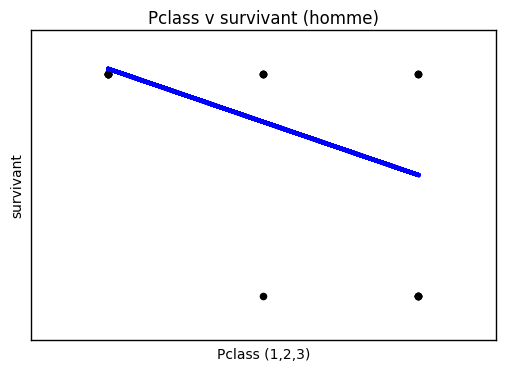

prediction pour 1ére classe 1.02
prediction pour 2éme classe 0.78
prediction pour 3éme classe 0.55


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model



# Split the data into training/testing sets
data_X_train = datap[datap['Sex']=='male']['Pclass'].to_frame()[:-20]
data_X_test = datap[datap['Sex']=='male']['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap[datap['Sex']=='male']['Survived'].to_frame()[:-20]
data_y_test = datap[datap['Sex']=='male']['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

# Plot outputs
plt.title('Pclass v survivant (homme)')
plt.scatter(data_X_test, data_y_test,  color='black')
plt.plot(data_X_test, regr.predict(data_X_test), color='blue',
         linewidth=3)
plt.xlabel('Pclass (1,2,3)')
plt.ylabel('survivant')
plt.xticks(())
plt.yticks(())

plt.show()

print(u'prediction pour 1ére classe {px:.2f}'.format(
        px=regr.predict([[1]])[0][0]))
print(u'prediction pour 2éme classe {px:.2f}'.format(
        px=regr.predict([[2]])[0][0]))
print(u'prediction pour 3éme classe {px:.2f}'.format(
        px=regr.predict([[3]])[0][0]))
print(' ')
print(' ')
print(' ')
print(' ')


# Split the data into training/testing sets
data_X_train = datap[datap['Sex']=='female']['Pclass'].to_frame()[:-20]
data_X_test = datap[datap['Sex']=='female']['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap[datap['Sex']=='female']['Survived'].to_frame()[:-20]
data_y_test = datap[datap['Sex']=='female']['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

# Plot outputs
plt.title('Pclass v survivant (homme)')
plt.scatter(data_X_test, data_y_test,  color='black')
plt.plot(data_X_test, regr.predict(data_X_test), color='blue',
         linewidth=3)
plt.xlabel('Pclass (1,2,3)')
plt.ylabel('survivant')
plt.xticks(())
plt.yticks(())

plt.show()

print(u'prediction pour 1ére classe {px:.2f}'.format(
        px=regr.predict([[1]])[0][0]))
print(u'prediction pour 2éme classe {px:.2f}'.format(
        px=regr.predict([[2]])[0][0]))
print(u'prediction pour 3éme classe {px:.2f}'.format(
        px=regr.predict([[3]])[0][0]))

On peut observer que les femmes ont pour chaque classe un taux de survie supérieur à 50% et un taux de survie de 100% en classe 1. Ce sont des régressions linéaires sur un jeu de données de test de 20 personnes, il se peut que quelque femme de classe 1 soit morte, mais la régression linéaire indique une tendance.
Pour les hommes, c'est complètement le contraire, leur taux de survie ne dépasse pas les 33% dans les meilleurs des cas. Cel peut descendre jusqu'à 13%.

On peut donc constater que ce sont les femmes qui tirent vers le haut les taux de survie. Et que sans les femmes, les taux de survie selon chaque classe ne seraient pas aussi distingués


Maintenant la même chose que précédemment en régression logistique

In [101]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Split the data into training/testing sets
data_X_train = datap[datap['Sex']=='male']['Pclass'].to_frame()[:-20]
data_X_test = datap[datap['Sex']=='male']['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap[datap['Sex']=='male']['Survived'].to_frame()[:-20]
data_y_test = datap[datap['Sex']=='male']['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LogisticRegression(C=1e5)

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

print('Pclass v survie (homme)')

# The coefficients
print('Coefficients: \n', regr.coef_)


print('prediction pour 1ére classe ')
print(regr.predict(1))
print('prediction pour 2éme classe ')
print(regr.predict(2))
print('prediction pour 3éme classe')
print(regr.predict(3))
print(' ')
print(' ')
print(' ')
print(' ')


# Split the data into training/testing sets
data_X_train = datap[datap['Sex']=='female']['Pclass'].to_frame()[:-20]
data_X_test = datap[datap['Sex']=='female']['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap[datap['Sex']=='female']['Survived'].to_frame()[:-20]
data_y_test = datap[datap['Sex']=='female']['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LogisticRegression(C=1e5)

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

print('Pclass v survie (femme)')

# The coefficients
print('Coefficients: \n', regr.coef_)

print('prediction pour 1ére classe ')
print(regr.predict(1))
print('prediction pour 2éme classe ')
print(regr.predict(2))
print('prediction pour 3éme classe')
print(regr.predict(3))

Pclass v survit (homme)
Coefficients: 
 [[-0.62524292]]
prediction pour 1ére classe 
[0]
prediction pour 2éme classe 
[0]
prediction pour 3éme classe
[0]
 
 
 
 
Pclass v survit (femme)
Coefficients: 
 [[-1.98745396]]
prediction pour 1ére classe 
[1]
prediction pour 2éme classe 
[1]
prediction pour 3éme classe
[1]


C:\Users\romain\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\romain\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On peut remarquer pour la régression logistique que toutes les femmes de chaque classes survient alors que tous les hommes meurent

<b> Test d'arbres décisionnels </b>

Nous allons tester les arbres de décision pour voir leur performance.
Le premier un l'algorithme de l'arbre de décision traditionnelle. il va calculer selon la classe si une personne survit ou non

In [70]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()

# Split the data into training/testing sets
data_X_train = datap['Pclass'].to_frame()[:-20]
data_X_test = datap['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap['Survived'].to_frame()[:-20]
data_y_test = datap['Survived'].to_frame()[-20:]

digit_tree=tree.fit(data_X_train,data_y_train)
# Estimation de l’erreur de prévision
res=digit_tree.score(data_X_test,data_y_test)
print ("erreur de prévision :")
print(res)
print(' ')
print(digit_tree.predict(data_X_test))
print(data_y_test)



erreur de prévision :
0.8
 
[1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0]
     Survived
871         1
872         0
873         0
874         1
875         1
876         0
877         0
878         0
879         1
880         1
881         0
882         0
883         0
884         0
885         0
886         0
887         1
888         0
889         1
890         0


On peut voir que l'algorithme de l'arbre de décision s'est trompé de 4 fois par rapport aux données de data y test sur un échantillon de 20 personnes mais il s'est seulement trompé de 2 par rapport au nombre de survivants.

l'algorithme à un coefficent de 0.8, donc un pouvoir prédictif forte.

In [32]:
#affichage de l'arbre sur une image
#je n'arrive pas à importer pydot pour le faire fonctionner
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
import matplotlib.pyplot as plt
dot_data = StringIO()
export_graphviz(digit_tree, out_file=dot_data)
graph=pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_png("arbreDecisionnel.png")

AttributeError: module 'matplotlib.pyplot' has no attribute 'graph_from_dot_data'

Nous allons donc tester le Random forest pour voir les différences avec l'arbre de décision.

C:\Users\romain\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


erreur de prévision sur le test
0.8
col_0                      0  1
row_0                          
(S, u, r, v, i, v, e, d)  15  5


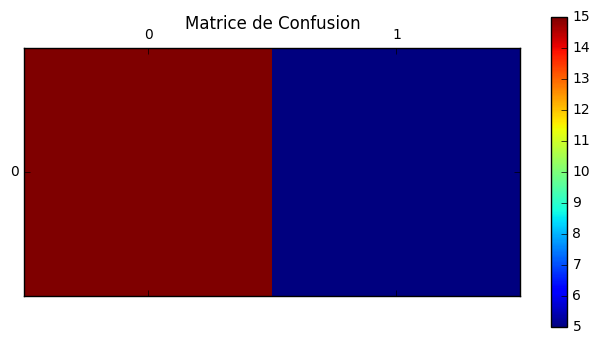

survivant et non survivant de la prediction
[1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0]
survivant et non survivant du data_test
     Survived
871         1
872         0
873         0
874         1
875         1
876         0
877         0
878         0
879         1
880         1
881         0
882         0
883         0
884         0
885         0
886         0
887         1
888         0
889         1
890         0


In [82]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500,
criterion='gini', max_depth=None,
min_samples_split=2, min_samples_leaf=1,
max_features='auto', max_leaf_nodes=None,
bootstrap=True, oob_score=True)

# Split the data into training/testing sets
data_X_train = datap['Pclass'].to_frame()[:-20]
data_X_test = datap['Pclass'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap['Survived'].to_frame()[:-20]
data_y_test = datap['Survived'].to_frame()[-20:]


forest = forest.fit(data_X_train,data_y_train)

# erreur de prévision sur le test
print('erreur de prévision sur le test')
print(forest.score(data_X_test,data_y_test))
# prévision
y_chap = forest.predict(data_X_test)

# matrice de confusion
table=pd.crosstab(data_y_test,y_chap)
print(table)
plt.matshow(table)
plt.title("Matrice de Confusion")
plt.colorbar()
plt.show()

print("survivant et non survivant de la prediction")
print(y_chap)
print("survivant et non survivant du data_test")
print(data_y_test)

On peut voir grâce à la matrice de confusion que le taux d'erreur est peu élevé. l'arbre aléatoire prévoit 5 survivants et 15 morts, alors qu'en réalité il y a 7 survivants et 13 morts.

l'algorithme de l'arbre de décision et du random forest renvoient la même prévision avec les mêmes coefficients.